In [1]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import json

from datetime import timedelta
from pathlib import Path

from pymeeus.Coordinates import velocity

%load_ext autoreload
%autoreload 2


# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

%aimport generation

from generation import generate
from parseRePEAT import *

# Plotting for the arrival time function
Top plot is the arrival time set out over the departure time

Bottom plot is the sum of the delay of the agents


In [2]:
def plot_atf(segments, axs, eatfs, **kwargs):
    color = kwargs.get('color', None)
    label = kwargs.get('label', None)
    y_offset = kwargs.get('y_offset', 0)
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1) + y_offset, 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0) + y_offset, float(y1) + y_offset], color=color)
    line.set_label(label) if line is not None else None

    plotted_intervals = []
    for path_eatf in eatfs.values():
        for (zeta, alpha, beta, delta, gammas) in path_eatf:
            min_gamma = 0
            max_gamma = 0
            for gamma_min, gamma_max, rt in gammas:
                # if gamma_max > gamma_min:
                #     raise ValueError(f"Max gamma > Min gamma, {gamma_max} > {gamma_min}")
                min_gamma += max(float(gamma_min) - float(rt), 0)
                max_gamma += max(float(gamma_max) - float(rt), 0)

            alpha = float(alpha)
            beta = float(beta)

            plotted_intervals.append((min(alpha, beta), beta, min_gamma, max_gamma))

            if alpha <= beta:
                # axs[1].plot([previous_beta, alpha], [min_gamma + y_offset, min_gamma + y_offset], color=color)
                axs[1].plot([alpha, beta], [min_gamma + y_offset, max_gamma + y_offset], color=color)
            # else:
            #     # axs[1].plot([previous_beta, beta - (gamma_diff)], [min_gamma + y_offset, min_gamma + y_offset], color=color)
            #     axs[1].plot([beta - (gamma_diff), beta], [min_gamma + y_offset, max_gamma + y_offset], color=color)
            # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)
            previous_beta = beta

    previous_beta = 0
    plotted_intervals.sort(key=lambda x: x[0])

    for (alpha, beta, min_gamma, max_gamma) in plotted_intervals:
        axs[1].plot([previous_beta, alpha], [min_gamma + y_offset, min_gamma + y_offset], color=color)
        previous_beta = beta

            # pybooklogger.info(f"{alpha}, {beta}, {gammas}, {min_gammas} - {max_gammas}")

In [3]:
def setup_plt(**kwargs):
    widths = [10]
    heights = [4, 1]
    fig, axs = plt.subplots(ncols=1, nrows=2, gridspec_kw={"height_ratios": heights, "width_ratios": widths})
    axs = axs.transpose()
    fig.set_figheight(7)
    fig.set_figwidth(15)

    axs[0].set_xlabel("Departure time (hh:mm:ss)")
    axs[1].set_xlabel("Departure time (hh:mm:ss)")
    axs[0].set_ylabel("Arrival time (hh:mm:ss)")
    axs[1].set_ylabel("Total delay of agents (s)")
    axs[0].set_title("Arrival Time Function")
    axs[0].set_xlim(left=kwargs.get("min_x", None), right=kwargs.get("max_x", None))
    axs[1].set_xlim(left=kwargs.get("min_x", None), right=kwargs.get("max_x", None))
    axs[0].set_ylim(bottom=kwargs.get("min_y", None), top=kwargs.get("max_y", None))
    axs[0].grid()
    axs[1].grid()

    axs[0].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[0].get_xticks()])
    axs[0].set_yticklabels([str(timedelta(seconds=ytick)) for ytick in axs[0].get_yticks()])
    axs[1].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[1].get_xticks()])

    return fig, axs

def plot_experiments(exps, save_path=None, **kwargs):
    fig, axs = setup_plt(**kwargs)
    for e in exps:
        if e.results is None:
            pybooklogger.info(f"No results found, skipping {e}")
            continue
        pybooklogger.info(f"Plotting {e}")
        e.plot(axs, **kwargs)

    axs[0].legend()
    if save_path:
        fig.savefig(f"figures/{save_path}")
    plt.show()

# Classes to setup for the experiment

## Agent
Represents a train, where the id is -1 for planning a new train, or the index of a train, starting at 1, of a train that is trying to replan in the scenarios file

In [4]:
class Agent:
    def __init__(self, id, origin, destination, velocity, start_time, **kwargs):
        self.id = id
        self.origin = origin
        self.destination = destination
        self.velocity = velocity
        self.start_time = start_time
        for key, value in kwargs.items():
            setattr(self, key, value)

    def __str__(self):
        return str(self.__dict__)

## Layout
holds to track layout and generates the track graph and route graph

In [5]:
class Layout:
    def __init__(self, layout):
        self.g, self.g_block, self.g_duration, self.g_block_duration = generate.time_graph_creation(layout)

    def station_to_block(self, station, direction=0):
        if station in self.g_block.stations:
            if direction == "A":
                direction = 0
            if direction == "B":
                direction = 1
            return self.g_block.stations[station][direction]
        pybooklogger.error(f"Station {station} not found")
        return station

    def get_path_for_agent(self, move, current_train, velocity):
        from generation.interval_generation import construct_path
        from generation.signal_sections import convertMovesToBlock

        path = construct_path(self.g, move, current_agent=current_train, agent_velocity=velocity)
        moves_per_agent = {current_train: [path]}
        return convertMovesToBlock(moves_per_agent, self.g, current_train)[current_train][0]

## Scenario
Holds the unsafe intervals for every agent in the scenario file

In [6]:
class Scenario:
    def __init__(self, l: Layout, scen_file, agent_id):
        self.l = l
        self.agent_id = agent_id
        self.block_intervals, self.moves_per_agent, self.unsafe_computation_time, self.block_routes, self.t_moves_to_block = generate.time_scenario_creation(scen_file, self.l.g, self.l.g_block, agent_id)

    def get_flexibility(self, max_buffer_time, use_recovery_time):
        return generate.time_flexibility_creation(self.block_routes, self.block_intervals, max_buffer_time, use_recovery_time)

    def plot(self, agent_to_plot_route_of, buffer_times, recovery_times, plot_route_of_agent_to_plot_route_of=True):
        exclude_agent=-1
        if not plot_route_of_agent_to_plot_route_of:
            exclude_agent=agent_to_plot_route_of
        generate.plot_route(agent_to_plot_route_of, self.moves_per_agent, self.block_routes, self.block_intervals, self.l.g_block, buffer_times, recovery_times, exclude_agent=exclude_agent)

## Experiment
Calculates the safe intervals given the max buffer time and recovery time.

Also can call the FlexSIPP search in C++.

In [7]:
class Experiment:
    def __init__(self, s: Scenario, agent: Agent, max_buffer_time, use_recovery_time, metadata):
        self.s = s
        self.agent = agent
        self.metadata= metadata

        self.buffer_times, self.recovery_times, self.time_flexibility_creation = s.get_flexibility(max_buffer_time, use_recovery_time)
        self.safe_block_intervals, self.safe_block_edges_intervals, self.atfs, self.indices_to_states, self.safe_computation_time = generate.time_interval_creation(self.s.block_intervals, self.s.l.g_block, self.buffer_times, self.recovery_times, self.agent.destination, agent.velocity)
        self.results = None

    def run_search(self, timeout):
        file = "output"
        generate.write_intervals_to_file(file, self.safe_block_intervals, self.atfs, self.indices_to_states)
        try:
            proc = subprocess.run(["../search/buildDir/atsipp.exe", "--start", self.agent.origin, "--goal", self.agent.destination, "--edgegraph", file, "--search", "repeat", "--startTime", str(self.agent.start_time)], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

        except subprocess.TimeoutExpired:
            pybooklogger.error(f'Timeout for repeat ({timeout}s) expired')
            return
        if int(proc.returncode) == 0:
            repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")
            pybooklogger.debug(f"repeat output: {repeat_output}")
            metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
            pybooklogger.info(f"eats: {eatfs}")
            pybooklogger.info(f"cats: {catf}")
            self.results = (metadata, catf, paths, eatfs)


    def plot(self, axs, **kwargs):
        plot_atf(self.results[1], axs, self.results[3], label=self.metadata["label"], color=self.metadata["color"], y_offset=self.metadata["offset"], **kwargs)

    def get_running_time(self):
        return {
            "unsafe interval generation": self.s.unsafe_computation_time,
            "safe interval generation": self.safe_computation_time,
            "bt and crt generation": self.time_flexibility_creation,
            "converting routes to blocks": self.s.t_moves_to_block,
            "track graph creation": self.s.l.g_duration,
            "routing graph creation": self.s.l.g_block_duration,
            "FlexSIPP search time": float(self.results[0]["Search time"]) / 1000.0,
            "Lookup time": float(self.results[0]["Lookup time"]) / 1000.0,
        }

    def get_complexity(self):
        return {
            "nodes generated": int(self.results[0]["Nodes generated"]),
            "nodes decreased": int(self.results[0]["Nodes decreased"]),
            "nodes expanded": int(self.results[0]["Nodes expanded"]),
        }

In [8]:
def run_experiments(exps: list[Experiment], timeout):
    for e in exps:
        e.run_search(timeout)

## Experiment setup
Create a list of experiments that can be run from the settings

In [9]:
def setup_experiment(scenario: Scenario, overwrite_settings):
    experiments = []
    for exp in overwrite_settings:
        set_default(exp)
        origin = exp["origin"]
        destination = exp["destination"]
        velocity = exp["velocity"]
        start_time = exp["start_time"]
        max_buffer_time = exp["max_buffer_time"]
        use_recovery_time = exp["use_recovery_time"]
        metadata = exp["metadata"]

        agent_id = scenario.agent_id
        pybooklogger.info(f"Setting up experiment {exp}")

        origin_signal = scenario.l.station_to_block(origin)
        destination_signal = scenario.l.station_to_block(destination)
        agent = Agent(agent_id, origin_signal, destination_signal, velocity, start_time)


        experiments.append(Experiment(scenario, agent, max_buffer_time, use_recovery_time, metadata))
    return experiments

## Default settings
Default settings for when not everything is specified

In [10]:
default_settings = {
    "origin": "ASD|13a",
    "destination": "RTD|2",
    "velocity": 140/3.6,
    "max_buffer_time": 0,
    "start_time": 0,
    "use_recovery_time": False,
    "metadata": {
        "color": "Red",
        "label": "No flexibility",
        "offset": 0,
    }
}

def _set_default(setting: dict, default: dict):
    for key, value in default.items():
        if key not in setting:
            setting[key] = value
        elif isinstance(value, dict):
            _set_default(setting[key], value)

def set_default(setting):
    _set_default(setting, default_settings)

# Track Layout
Calculate the layout of the dutch railway system


In [11]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

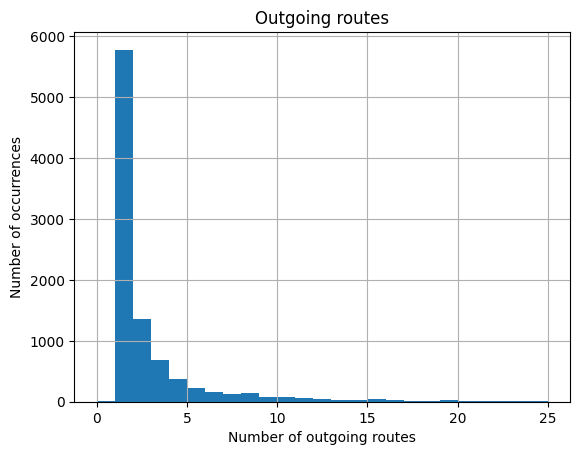

In [12]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

# Agents

In [13]:
scenario_file = "../data/prorail/scenarios/SHL-2025-06-30.json"
try:
    base_path = Path(__file__).parent
    file_path = (base_path / scenario_file).resolve()
    data = json.load(open(file_path))
except:
    data = json.load(open(scenario_file))
types = {x["name"]: x for x in data["types"]}
agents = []
for trainNumber, entry in enumerate(data["trains"]):
    trainNumber += 1
    move = entry["movements"][0]
    velocity = types[entry["trainUnitTypes"][0]]["speed"] / 3.6

    block_path = layout.get_path_for_agent(move, trainNumber, velocity)

    agent = Agent(trainNumber, move["startLocation"], move["endLocation"], velocity, move["startTime"],
                  endTime=move["endTime"],
                  startTimeHuman=str(timedelta(seconds=move["startTime"])),
                  endTimeHuman=str(timedelta(seconds=move["endTime"])),
                  blockPath=block_path
    )
    agents.append(agent)

agent_df = pd.DataFrame([agent.__dict__ for agent in agents])
agent_df['blockPathLength'] = agent_df['blockPath'].map(len)


In [14]:

print(f"total blocks in path: {agent_df['blockPathLength'].sum()}")
print(f"total edges in graph: {edges_df['Outgoing routes'].sum()}")

agent_df

total blocks in path: 6156
total edges in graph: 23191


,id,origin,destination,velocity,start_time,endTime,startTimeHuman,endTimeHuman,blockPath,blockPathLength
0,1,SHL|5,RTD|11,55.555556,1080.0,2640.0,0:18:00,0:44:00,"[r-Shl|1078--r-Shl|1098, r-Shl|1098--r-Hfd_Shl...",61
1,2,RTD|12,AMFS|2,55.555556,780.0,5160.0,0:13:00,1:26:00,"[r-Rtd|272--r-Rtd|178, r-Rtd|178--r-Rmoa_Rtd|1...",119
2,3,DDR|5,GVC|2,38.888889,240.0,3360.0,0:04:00,0:56:00,"[r-Ddr|1232--r-Ddr|1306, r-Ddr|1306--r-Zwd|131...",47
3,4,ASDL|1,HFD|2,38.888889,60.0,840.0,0:01:00,0:14:00,"[r-Asdl|954--r-Asdl_Asra|1829, r-Asdl_Asra|182...",13
4,5,PMO|1,LEDN|8a,38.888889,660.0,4260.0,0:11:00,1:11:00,"[r-Pmo|170--r-Pmo_Zdk|655, r-Pmo_Zdk|655--r-Pm...",51
...,...,...,...,...,...,...,...,...,...,...
88,89,LEDN|2,UT|20,38.888889,600.0,3780.0,0:10:00,1:03:00,"[r-Ledn|1082--r-Ledn|1128, r-Ledn|1128--r-Ld|1...",35
89,90,SHL|5,GVC|9,38.888889,60.0,1860.0,0:01:00,0:31:00,"[r-Shl|1078--r-Shl|1098, r-Shl|1098--r-Hfd_Shl...",34
90,91,DDR|2,VL|3,38.888889,2160.0,14400.0,0:36:00,4:00:00,"[r-Ddr|1238--r-Ddr|1306, r-Ddr|1306--r-Zwd|131...",233
91,92,RTD|13,GVC|2,38.888889,1200.0,2580.0,0:20:00,0:43:00,"[r-Rtd|270--r-Rtd|178, r-Rtd|178--r-Rmoa_Rtd|1...",28


# Experiment Shl -> Rtd

Second experiment as described in the thesis, where we plan in an extra train from Schiphol to Rotterdam, not going over the HSL line but through Leiden and The Hague.


## Scenario
First load the scenario where we don't include agent 1 (used for plotting the path) that is the Eurostar train.

In [15]:
scenario_file = "../data/prorail/scenarios/SHL-2025-06-30.json"
# Replan these agents, -1 is planning in a new agent
agent_id = 1
scenario = Scenario(layout, scenario_file, agent_id)

## Experiment
Define three experiments:
1. Classical @SIPP, no extra flexibility
2. FlexSIPP but not including the recovery time
3. FlexSIPP

In [16]:
# Setup experiment
experiment_settings = [
    {
        "start_time": 1080,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "metadata": {
            "offset": 2,
        }
    },
    {
        "start_time": 1080,
        "max_buffer_time": 500,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "metadata": {
            "color": "Green",
            "label": "Buffer time",
            "offset": 1,
        }
    },{
        "start_time": 1080,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "max_buffer_time": 500,
        "use_recovery_time": True,
        "metadata": {
            "color": "Blue",
            "label": "Recovery time",
        }
    }
]

logger.setLevel(logging.CRITICAL)
experiments = setup_experiment(scenario, experiment_settings)

INFO:pybook:Setting up experiment {'start_time': 1080, 'origin': 'SHL|6', 'destination': 'RTD|2', 'metadata': {'offset': 2, 'color': 'Red', 'label': 'No flexibility'}, 'velocity': 38.888888888888886, 'max_buffer_time': 0, 'use_recovery_time': False}
INFO:pybook:Setting up experiment {'start_time': 1080, 'max_buffer_time': 500, 'origin': 'SHL|6', 'destination': 'RTD|2', 'metadata': {'color': 'Green', 'label': 'Buffer time', 'offset': 1}, 'velocity': 38.888888888888886, 'use_recovery_time': False}
INFO:pybook:Setting up experiment {'start_time': 1080, 'origin': 'SHL|6', 'destination': 'RTD|2', 'max_buffer_time': 500, 'use_recovery_time': True, 'metadata': {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}, 'velocity': 38.888888888888886}


### Blocking staircase diagram
Showing the route of Shl -> Rtd

C:\Users\erick\Documents\uni\Thesis\delay-replannning\generation\safe_interval_graph.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(timedelta(seconds=ytick)) for ytick in ax.get_yticks()])


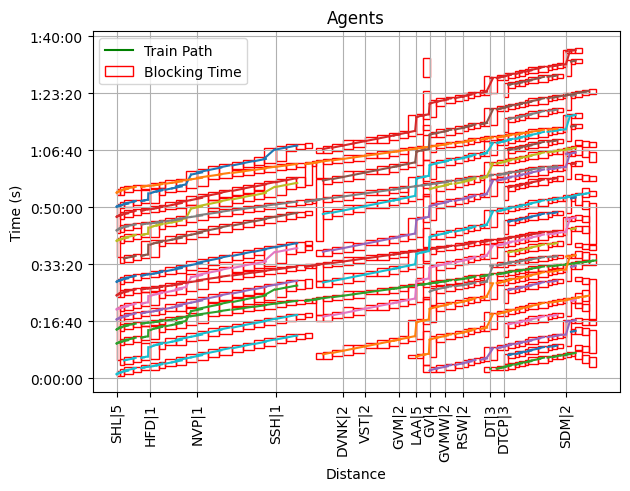

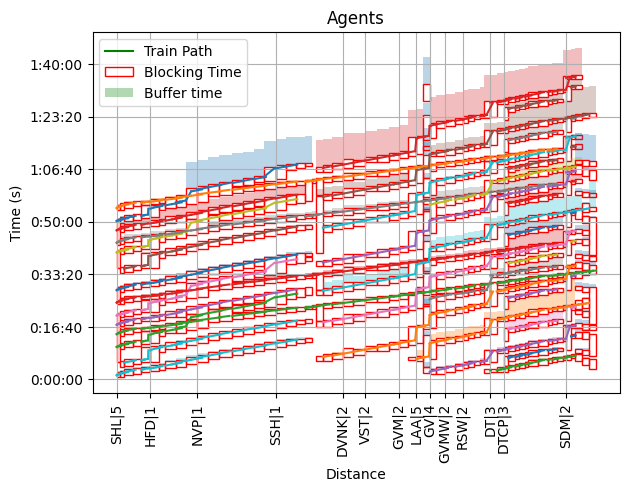

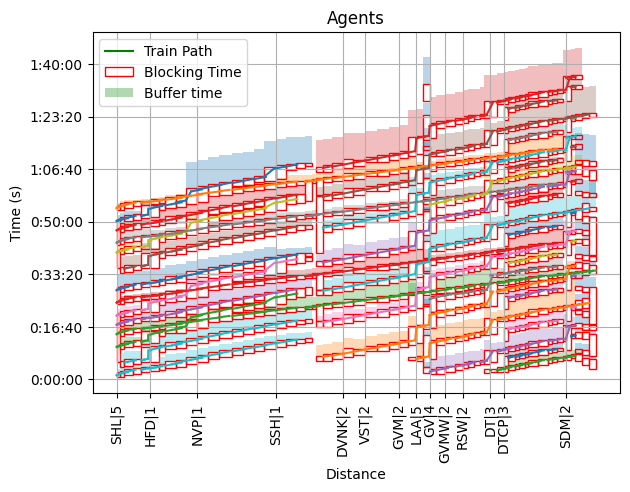

In [17]:
for exp in experiments:
    exp.s.plot(1, exp.buffer_times, exp.recovery_times, False)

In [18]:
timeout = 600
run_experiments(experiments, timeout)

DEBUG:pybook:repeat output: ['<0,inf,inf,inf> <-inf,1804.69,5010.02,5010.02>', '<1804.69,inf,inf,inf> <-inf,3734.81,5704.95,5704.95>', '<3734.81,inf,inf,inf> <-inf,4026.11,5704.95,5704.95>', '<-inf,3734.81,5704.95,5704.95> <-inf,4026.11,5704.95,5704.95>', '<4026.11,inf,inf,inf> <4026.11,27121.2,5704.95,28800>', '<3734.81,4026.11,5704.95,5704.95> <4026.11,27121.2,5704.95,28800>', '<-inf,3734.81,5704.95,5704.95> <3734.81,4026.11,5704.95,5704.95>', 'Nodes generated: 1927 Nodes decreased: 391 Nodes expanded: 1352', '<-inf,1804.69,5010.02,5010.02>, <-inf,3734.81,5704.95,5704.95>, <3734.81,4026.11,5704.95,5704.95>, <4026.11,27121.2,5704.95,28800>, <27121.2,inf,inf,inf>, ', 'r-Shl|1080 <0,28800> ns:5 []', 'r-Shl|1098 <1750.43,2123.72> ns:1 []', 'r-Hfd_Shl|1757 <1779.62,2026.01> ns:1 []', 'r-Hfd_Shl|1771 <1815.75,2044.8> ns:1 []', 'r-Hfd|1106 <1826.16,2076.03> ns:7 []', 'r-Hfd|1126 <0,28800> ns:3 []', 'r-Hfd|1160 <0,28800> ns:21 []', 'r-Hfd|1116 <0,28800> ns:42 []', 'r-Hfd_Shl|1776 <1601.91,20

## Results
### ATF Plot

C:\Users\erick\AppData\Local\Temp\ipykernel_1656\3665184093.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[0].get_xticks()])
C:\Users\erick\AppData\Local\Temp\ipykernel_1656\3665184093.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([str(timedelta(seconds=ytick)) for ytick in axs[0].get_yticks()])
C:\Users\erick\AppData\Local\Temp\ipykernel_1656\3665184093.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[1].get_xticks()])


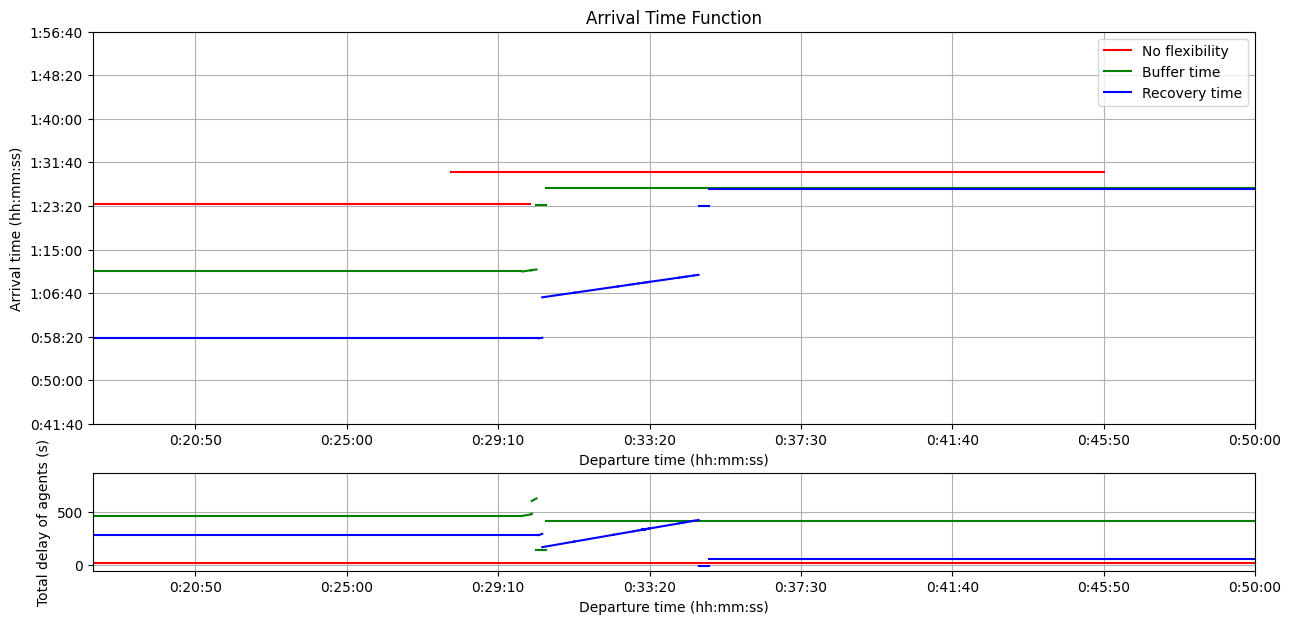

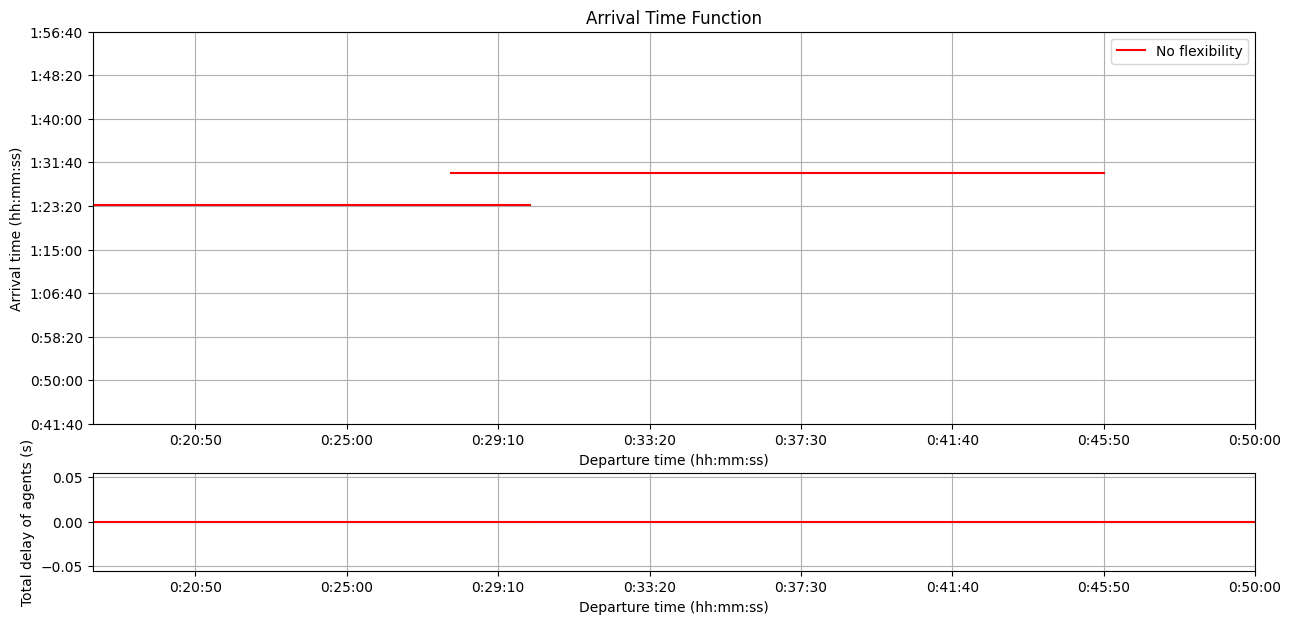

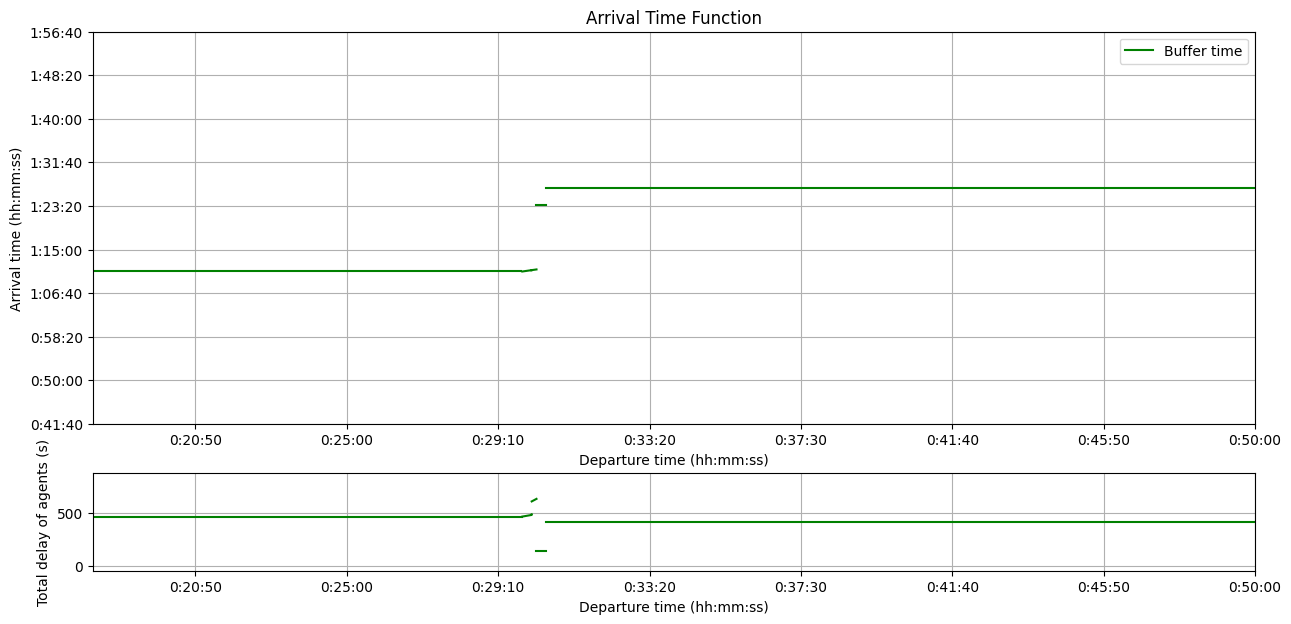

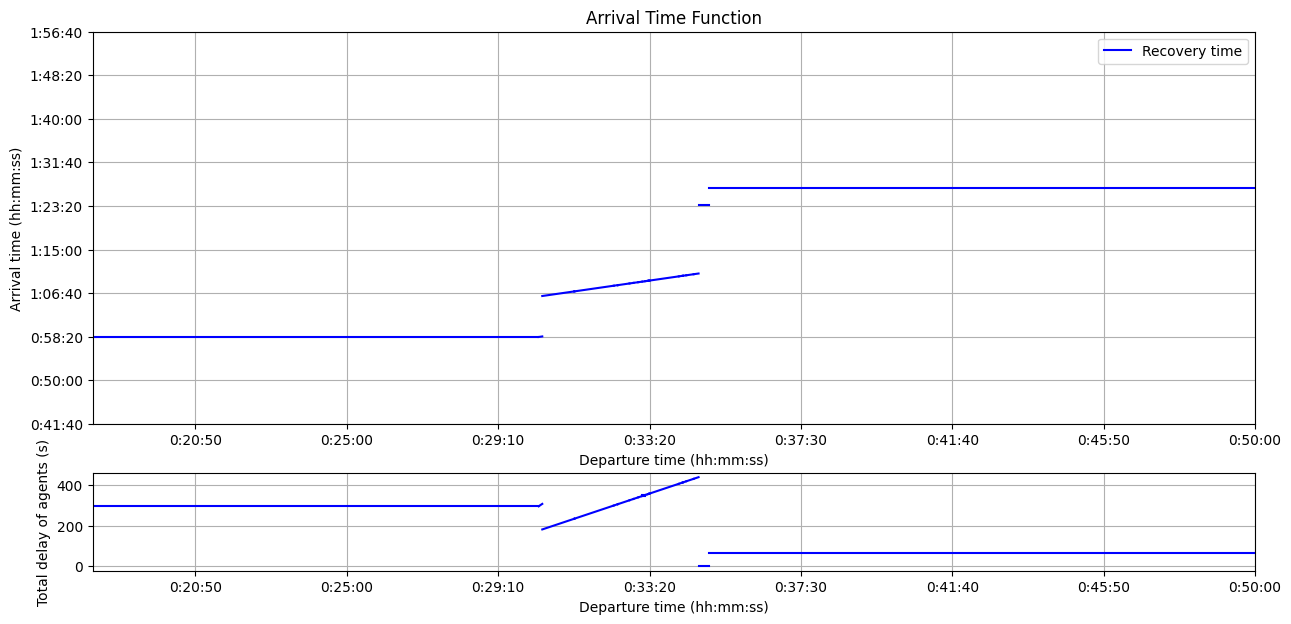

In [19]:
pybooklogger.setLevel(logging.WARNING)
experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 15}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': -15}
experiments[0].results[1][1] = ('1672.78', '2750.88', '5377.17', '5377.17')

kwargs = {"min_x": 1080, "max_x": 3000, "min_y": 2500, "max_y": 7000}
plot_experiments(experiments, **kwargs)


experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 0}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}

plot_experiments([experiments[0]], **kwargs)
plot_experiments([experiments[1]], **kwargs)
plot_experiments([experiments[2]], **kwargs)

### Time statistics

In [20]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame([exp.get_running_time() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")

print(time_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Lookup time &  Setup Time &  Recompute Time &  Search Time \\
\midrule
No flexibility &          6.2 &   63.856327 &      267.569816 &       45.182 \\
Buffer time    &          7.3 &   63.856327 &      267.567537 &       74.772 \\
Recovery time  &          6.0 &   63.856327 &      267.609400 &      227.425 \\
\bottomrule
\end{tabular}



### Search Node Statistics

In [21]:
nodes_df = pd.DataFrame([exp.get_complexity() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

print(nodes_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  nodes generated &  nodes decreased &  nodes expanded \\
\midrule
No flexibility &             1927 &              391 &            1352 \\
Buffer time    &             3827 &             3089 &            2317 \\
Recovery time  &            10715 &             7944 &            6902 \\
\bottomrule
\end{tabular}



### Output paths found

In [22]:
for key, value in experiments[2].results[3].items():
    delayed_trains = {i: v for i,v in enumerate(value[0][4]) if float(v[0]) > 0}
    print(f"{key.replace('r-', '')}\nearliest departure: {int(min(float(value[0][1]), float(value[0][2])) / 60)}\ndepart before: {int(float(value[0][2]) / 60)}\narrive at: {int((float(value[0][1]) + float(value[0][3])) / 60)}\ndelays trains: {delayed_trains}")

Shl|1080;Shl|1098;Hfd_Shl|1757;Hfd_Shl|1771;Hfd|1106;Hfd|1130;Hfd|1148;Hfd|1202;Hfd|1228;Hfd_Ledn|1969;Hfd_Ledn|1971;Hfd_Ledn|1973;Hfd_Ledn|1975;Hfd_Ledn|1977;Hfd_Ledn|1979;Hfd_Ledn|1981;Hfd_Ledn|1983;Hfd_Ledn|1985;Hfd_Ledn|1987;Hfd_Ledn|1991;Ledn|1010;Ledn|1046;Ledn|1090;Gvm_Ledn|803;Gvm_Ledn|813;Gvm_Ledn|823;Gvm_Ledn|833;Gvm_Ledn|843;Gvm_Ledn|853;Gvm|154;Gvm|186;Laa|529;Laa|537;Laa|94;Gv|228;Gv|300;Gv|328;Dt_Gv|605;Dt_Gv|613;Dt_Gv|621;Dt_Gv|629;Dt|643;Dt|6136;Dt|6166;Dt|6186;Dt|6206;Dtcp|6246;Dtcp|6266;Dt_Sdm|803;Dt_Sdm|809;Dt_Sdm|815;Dt_Sdm|819;Dt_Sdm|825;Dt_Sdm|831;Dt_Sdm|835;Sdm|38;Sdm|48;Sdm|68;Sdm|98;Rmoa_Rtd|120;Rmoa_Rtd|160;Rtd|172;Rtd|236;Rtd|344
earliest departure: 30
depart before: 30
arrive at: 58
delays trains: {3: ['201.564', '207.536', '197.977'], 17: ['42.5697', '48.5421', '543.163'], 27: ['432.003', '437.975', '1729.76'], 70: ['295.108', '301.081', '2.42442'], 88: ['138.205', '144.177', '862.644']}
Shl|1080;Shl|1098;Hfd_Shl|1757;Hfd_Shl|1771;Hfd|1106;Hfd|1130;Hfd|1148

### Path statistics

In [23]:
for exp in experiments:
    print(f"Differend paths found for {exp.metadata['label']}: {sum(exp.results[2].values())}")

Differend paths found for No flexibility: 4
Differend paths found for Buffer time: 27
Differend paths found for Recovery time: 67
